In [7]:
import pandas as pd
from acled_conflict_analysis import analysis
from acled_conflict_analysis import visuals
import ast
import json
import geopandas as gpd
from shapely.geometry import Point
#import dask_geopandas as dgpd
#import dask.dataframe as dd

import glob

# Air Pollution in Ethiopia

In [8]:
ethiopia_adm1 = gpd.read_file('../../data/boundaries/eth_admbnda_adm1_csa_bofedb_2021.shp')
ethiopia_adm2 = gpd.read_file('../../data/boundaries/eth_admbnda_adm2_csa_bofedb_2021.shp')

In [25]:
def get_annual_baseline(df, group_column='ADM1_EN', baseline_year='PY'):
    df = df.copy()
    df['year'] = df['event_date'].dt.year
    baseline_column = f'baseline_NO2_{baseline_year}'
    column_name = f'percent_change_NO2_{baseline_year}'

    if isinstance(baseline_year, int):  # Fixed baseline year case
        # Compute annual baseline NO2 for the specified baseline year
        
        baseline_df = (
            df[df['year'] == baseline_year]
            .groupby(group_column)['NO2']
            .mean()
            .reset_index()
            .rename(columns={'NO2': baseline_column})
        )

        # Merge the fixed-year baseline into the original DataFrame
        df = df.merge(baseline_df, on=[group_column], how='left')    

    # Compute the annual percentage change
        df[column_name] = ((df['NO2'] - df[baseline_column]) / df[baseline_column]) * 100

    elif baseline_year == 'PY':  # Previous year case
        df[baseline_column] = None  # Initialize column for baseline NO2 values

        # Get all unique years in the dataset
        years = sorted(df['year'].unique())

        # Iterate through each year (starting from the second year in the dataset)
        for year in years[1:]:  # Ensure there's a previous year
            # Compute the previous year's annual baseline
            baseline_df = (
                df[df['year'] == year - 1]  # Get the previous year's data
                .groupby(group_column)['NO2']
                .mean()
                .rename(baseline_column)
            )

            # Use .map() to assign the previous year's NO2 values correctly
            df.loc[df['year'] == year, baseline_column] = df.loc[df['year'] == year, group_column].map(baseline_df)

            df[column_name] = ((df['NO2'] - df[baseline_column]) / df[baseline_column]) * 100

    else:
        raise ValueError("Invalid baseline_year argument. Use an integer for a fixed year or 'PY' for previous year.")
    
    

    return df


In [26]:
def get_monthly_baseline(df, group_column, baseline_year='PY'):
    df = df.copy()
    df['year'] = df['event_date'].dt.year
    df['month'] = df['event_date'].dt.month
    baseline_column = f'baseline_NO2_{baseline_year}'
    column_name = f'percent_change_NO2_{baseline_year}'

    if isinstance(baseline_year, int):  # Fixed baseline year case
        # Compute monthly NO2 baseline for the specified baseline year
        baseline_df = (
            df[df['year'] == baseline_year]
            .groupby([group_column, 'month'])['NO2']
            .mean()
            .reset_index()
            .rename(columns={'NO2': baseline_column})
        )

        # Merge the fixed-year baseline into the original DataFrame
        df = df.merge(baseline_df, on=[group_column, 'month'], how='left')

        df[column_name] = ((df['NO2'] - df[baseline_column]) / df[baseline_column]) * 100

    elif baseline_year == 'PY':  # Previous year case
        df[baseline_column] = None  # Initialize column for baseline NO2 values

        # Get all unique years in the dataset
        years = sorted(df['year'].unique())

        # Iterate through each year (starting from the second year in the dataset)
        for year in years[1:]:  # Ensure there's a previous year
            # Compute the previous year's monthly baseline
            baseline_df = (
                df[df['year'] == year - 1]  # Get the previous year's data
                .groupby([group_column, 'month'])['NO2']
                .mean()
                .rename(baseline_column)
            )

            # Use .map() to assign the previous year's NO2 values correctly
            df.loc[df['year'] == year, baseline_column] = df.loc[df['year'] == year, [group_column, 'month']].apply(
                lambda row: baseline_df.get((row[group_column], row['month'])), axis=1
            )

            df[column_name] = ((df['NO2'] - df[baseline_column]) / df[baseline_column]) * 100

    else:
        raise ValueError("Invalid baseline_year argument. Use an integer for a fixed year or 'PY' for previous year.")
    
    column_name = f'percent_change_NO2_{baseline_year}'

    # Compute the monthly percentage change
    

    return df


In [5]:
def clean_air_pollution(df):
    if 'system:index' in df.columns:
        df.drop(columns='system:index', inplace=True)

    if '.geo' in df.columns:
        df.drop(columns='.geo', inplace=True)
    
    if 'admin0Name' in df.columns:
        df.rename(columns={'admin0Name':'ADM0_EN', 'admin1Name':'ADM1_EN', 'admin2Name':'ADM2_EN'}, inplace=True)
        
    #df = df[['ADM0_EN', 'ADM1_EN', 'date','mean']]

    df.rename(columns={'date':'event_date', 'mean':'mean_NO2', 'NO2_column_number_density':'NO2', 'startMonth':'event_date'}, inplace=True)
    df['event_date'] = pd.to_datetime(df['event_date'])

    

In [3]:
def match_raw_file_columns(df):
    if 'ADM1_EN' in df.columns or 'ADM0_EN' in df.columns:
        df.rename(columns={'ADM0_EN':'admin0Name', 'ADM1_EN':'admin1Name', 'mean':'NO2'}, inplace=True)


In [50]:
#air_pollution = pd.read_csv('../../data/air_pollution/no2_ethiopia_20230101_20230103.csv')
air_pollution_monthly_adm1 = pd.concat([pd.read_csv('../../data/air_pollution/adm1/ETH_ADM1_Monthly_NO2_2019_2024.csv'),
                                        match_raw_file_columns(pd.read_csv('../../data/air_pollution/adm1/ETH_ADM1_no2_monthly_202410.csv')),
                                        match_raw_file_columns(pd.read_csv('../../data/air_pollution/adm1/ETH_ADM1_no2_monthly_202411.csv')),
                                        match_raw_file_columns(pd.read_csv('../../data/air_pollution/adm1/ETH_ADM1_no2_monthly_202412.csv'))])
clean_air_pollution(air_pollution_monthly_adm1)

air_pollution_monthly_adm1 = ethiopia_adm1[['ADM0_EN', 'ADM1_EN', 'geometry']].merge(air_pollution_monthly_adm1[['ADM0_EN', 'ADM1_EN', 'event_date','NO2']], on =['ADM0_EN','ADM1_EN'])

In [10]:
air_pollution_monthly_adm1.to_csv('../../data/air_pollution/processed/air_pollution_monthly_adm1_2019_2024.csv')

In [51]:
air_pollution_annual_adm1 = air_pollution_monthly_adm1.groupby([pd.Grouper(key='event_date', freq='YS'), 'ADM1_EN'])['NO2'].mean().reset_index()
air_pollution_annual_adm1 = get_annual_baseline(air_pollution_annual_adm1, baseline_year=2019, group_column='ADM1_EN')
air_pollution_annual_adm1 = get_annual_baseline(air_pollution_annual_adm1, baseline_year='PY', group_column='ADM1_EN')

air_pollution_monthly_adm1 = get_monthly_baseline(air_pollution_monthly_adm1, baseline_year=2019, group_column='ADM1_EN')
air_pollution_monthly_adm1 = get_monthly_baseline(air_pollution_monthly_adm1, baseline_year='PY', group_column='ADM1_EN')

In [52]:
air_pollution_annual_adm0 = air_pollution_monthly_adm1.groupby([pd.Grouper(key='event_date', freq='YS'), 'ADM0_EN'])['NO2'].mean().reset_index()
air_pollution_monthly_adm0 = air_pollution_monthly_adm1.groupby([pd.Grouper(key='event_date', freq='MS'), 'ADM0_EN'])['NO2'].mean().reset_index()

air_pollution_annual_adm0 = get_annual_baseline(air_pollution_annual_adm0, baseline_year=2019, group_column='ADM0_EN')
air_pollution_annual_adm0 = get_annual_baseline(air_pollution_annual_adm0, baseline_year='PY', group_column='ADM0_EN')

air_pollution_monthly_adm0 = get_monthly_baseline(air_pollution_monthly_adm0, baseline_year=2019, group_column='ADM0_EN')
air_pollution_monthly_adm0 = get_monthly_baseline(air_pollution_monthly_adm0, baseline_year='PY', group_column='ADM0_EN')

In [18]:
air_pollution_monthly_adm3 = pd.read_csv('../../data/air_pollution/processed/eth_adm3_no2_monthly_2019_2024.csv')
air_pollution_monthly_adm3.drop(columns='date', inplace=True)
air_pollution_monthly_adm3.rename(columns={'start_date':'date'}, inplace=True)
air_pollution_monthly_adm3['date'] = pd.to_datetime(air_pollution_monthly_adm3['date'])

C:\Users\wb588851\AppData\Local\Temp\ipykernel_7140\291022965.py:1: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  air_pollution_monthly_adm3 = pd.read_csv('../../data/air_pollution/processed/eth_adm3_no2_monthly_2019_2024.csv')


In [21]:
air_pollution_annual_adm3 = air_pollution_monthly_adm3.groupby(['ADM0_EN', 'ADM1_EN', 'ADM2_EN', 'ADM3_EN', pd.Grouper(key='date', freq='YS')])['mean'].mean().reset_index()

In [23]:
ethiopia_adm3 = gpd.read_file('../../data/boundaries/eth_admbnda_adm3_csa_bofedb_2021.shp')
air_pollution_annual_adm3_gdf = ethiopia_adm3[['ADM1_EN', 'ADM2_EN', 'ADM3_EN', 'geometry']].merge(air_pollution_annual_adm3)


## Temporal Pollution Trends

First we look at the temporal trends nationally and regionally at annual and monthly levels. 

In [58]:
air_pollution_monthly_adm2 = pd.concat([pd.read_csv('../../data/air_pollution/adm2/ETH_ADM2_Monthly_NO2_2019_2021.csv'),
                                        pd.read_csv('../../data/air_pollution/adm2/ETH_ADM2_Monthly_NO2_2022_2023.csv'),
                                        pd.read_csv('../../data/air_pollution/adm2/ETH_ADM2_Monthly_NO2_2024_2024.csv')])

clean_air_pollution(air_pollution_monthly_adm2)
air_pollution_monthly_adm2 = ethiopia_adm2[['ADM0_EN', 'ADM1_EN', 'ADM2_EN', 'geometry']].merge(air_pollution_monthly_adm2, on = ['ADM0_EN', 'ADM1_EN', 'ADM2_EN'])

In [59]:
air_pollution_monthly_adm2.to_csv('../../data/air_pollution/processed/air_pollution_monthly_adm2_2019_2024.csv')

### National Trends

In [53]:
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel
bokeh.core.validation.silence(MISSING_RENDERERS, True)


output_notebook()

# Grouping and calculating the monthly mean by aoi
df = air_pollution_monthly_adm0

# Group by year and calculate the yearly average NO2
df['year'] = pd.DatetimeIndex(df['event_date']).year
yearly_avg = df.groupby('year')['NO2'].mean().reset_index()

tabs = []
labels = ['Monthly National Air Pollution', '% Change in Air Pollution compared to 2019', '% Change in Air Pollution Compared to Previous Year']

for idx, measure in enumerate(['NO2', 'percent_change_NO2_2019', 'percent_change_NO2_PY']):
    # Get the line plot for monthly NO2
    p = visuals.get_line_plot(
                df,
                labels[idx],
                "Source: Sentinel 5-P extracted from Google Earth Engine",
                subtitle = "",
                category = 'ADM0_EN',
                measure=measure
    )

    # # Add a line for yearly averages
    # # Assuming you have a way to map the 'year' values to a datetime format for the x-axis in the plot
    p.children[1].line(x=pd.to_datetime(air_pollution_annual_adm0['event_date'].dt.year, format='%Y'), y=air_pollution_annual_adm0[measure], 
        line_width=2, color='red', legend_label=f'Yearly Average {measure}')
    
    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with both the monthly and yearly average lines
tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

### Regional Trends

In [117]:
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel
bokeh.core.validation.silence(MISSING_RENDERERS, True)


output_notebook()

# Grouping and calculating the monthly mean by aoi
df = air_pollution_annual_adm1

# Group by year and calculate the yearly average NO2
df['year'] = pd.DatetimeIndex(df['event_date']).year

tabs = []
labels = ['Annual Regional Air Pollution', '% Change in Regional Air Pollution compared to 2019', '% Change in Regional Air Pollution Compared to Previous Year']


for idx, measure in enumerate(['NO2', 'percent_change_NO2_2019', 'percent_change_NO2_PY']):
    # Get the line plot for monthly NO2
    p = visuals.get_line_plot(
                df,
                labels[idx],
                "Source: Sentinel 5-P extracted from Google Earth Engine",
                subtitle = "",
                category = 'ADM1_EN',
                measure=measure
    )

    # # Add a line for yearly averages
    # # Assuming you have a way to map the 'year' values to a datetime format for the x-axis in the plot
    # p.children[1].line(x=pd.to_datetime(air_pollution_annual_adm1['event_date'].dt.year, format='%Y'), y=air_pollution_annual_adm1[measure], 
    #     line_width=2, color='red', legend_label=f'Yearly Average {measure}')
    
    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with both the monthly and yearly average lines
tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

In [13]:
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel
bokeh.core.validation.silence(MISSING_RENDERERS, True)


output_notebook()

# Grouping and calculating the monthly mean by aoi
df = air_pollution_monthly_adm1

# Group by year and calculate the yearly average NO2
df['year'] = pd.DatetimeIndex(df['event_date']).year

tabs = []
labels = ['Monthly Regional Air Pollution', '% Change in Regional Air Pollution compared to 2019', '% Change in Regional Air Pollution Compared to Previous Year']


for idx, measure in enumerate(['NO2', 'percent_change_NO2_2019', 'percent_change_NO2_PY']):
    # Get the line plot for monthly NO2
    p = visuals.get_line_plot(
                df,
                labels[idx],
                "Source: Sentinel 5-P extracted from Google Earth Engine",
                subtitle = "",
                category = 'ADM1_EN',
                measure=measure
    )

    # # Add a line for yearly averages
    # # Assuming you have a way to map the 'year' values to a datetime format for the x-axis in the plot
    # p.children[1].line(x=pd.to_datetime(air_pollution_annual_adm1['event_date'].dt.year, format='%Y'), y=air_pollution_annual_adm1[measure], 
    #     line_width=2, color='red', legend_label=f'Yearly Average {measure}')
    
    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with both the monthly and yearly average lines
tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

In [60]:
air_pollution_annual_adm2 = air_pollution_monthly_adm2.groupby([pd.Grouper(key='event_date', freq='YS'), 'ADM2_EN'])['NO2'].mean().reset_index()
air_pollution_annual_adm2 = get_annual_baseline(air_pollution_annual_adm2, baseline_year=2019, group_column='ADM2_EN')
air_pollution_annual_adm2 = get_annual_baseline(air_pollution_annual_adm2, baseline_year='PY', group_column='ADM2_EN')

In [95]:
def plot_regional_timeseries(df, variable_column, percent_change_column=None, time_column='event_date', 
                            region_column='ADM1_EN', geometry_df=None, geometry_region_column='ADM1_EN', 
                            years=None, exclude_years=None, pc_change=False, 
                            cmap='viridis', figsize=(16, 4), title=None,
                            highlight_regions=None, highlight_color='red', highlight_linewidth=2):
    """
    Plot regional values over time with options for percent change visualization.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame containing time series data by region
    variable_column : str
        Name of the column containing values to plot (e.g., 'NO2')
    percent_change_column : str
        Name of existing column containing percent change values (e.g., 'percent_change_NO2_PY')
    time_column : str
        Name of the column containing date information (default: 'event_date')
    region_column : str
        Name of the column containing region identifiers (default: 'ADM1_EN')
    geometry_df : GeoDataFrame
        GeoDataFrame containing region boundaries (default: None)
    geometry_region_column : str
        Name of region column in geometry_df (default: 'ADM1_EN')
    years : list
        List of years to include in plot (default: None, will use all years)
    exclude_years : list
        List of years to exclude from plot (default: None)
    pc_change : bool
        Whether to plot percent change instead of absolute values (default: False)
    cmap : str or matplotlib colormap
        Matplotlib colormap to use (default: 'viridis')
    figsize : tuple
        Figure size (width, height) in inches (default: (16, 4))
    title : str
        Custom title for the chart (default: None, will use auto-generated title)
    highlight_regions : list
        List of region names to highlight with a boundary (default: None)
    highlight_color : str
        Color to use for highlighted region boundaries (default: 'red')
    highlight_linewidth : int
        Line width for highlighted region boundaries (default: 2)
        
    Returns:
    --------
    fig : matplotlib Figure
        The figure object containing the plots
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import pandas as pd
    import numpy as np
    
    # Ensure the date column is a datetime
    df[time_column] = pd.to_datetime(df[time_column])
    
    # Determine years to plot if not specified
    if years is None:
        years = sorted(df[time_column].dt.year.unique())
    
    # Exclude specified years
    if exclude_years:
        years = [y for y in years if y not in exclude_years]
    
    # Create a figure with subplots (one for each year plus one for the colorbar)
    fig, ax = plt.subplots(1, len(years) + 1, figsize=figsize, 
                          gridspec_kw={'width_ratios': [1] * len(years) + [0.3]})
    
    # Flatten the axes array for easier indexing
    ax = ax.flatten()
    
    # Setup custom colormap for percent change if specified
    if pc_change:
        colors = ["#754493", "#A873C4", "#D1AEE3", "#EFEFEF", "#98CBCC", "#4EA2AC", "#24768E"]
        custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
        cmap = custom_cmap
    
    # Determine which column to plot based on whether we're plotting percent change
    plot_column = percent_change_column if pc_change and percent_change_column else variable_column
    
    # Get min and max values for consistent color scaling
    if pc_change and percent_change_column:
        
        vmin = df[df[time_column].dt.year.isin(years)][percent_change_column].min()
        #print(vmin)
        vmax = df[df[time_column].dt.year.isin(years)][percent_change_column].max()
        
        # For percent change, make sure the colormap is centered at 0
        # if abs(vmin) > abs(vmax):
        #     vmax = abs(vmin)
        # else:
        #     vmin = -abs(vmax)
    else:
        vmin = df[df[time_column].dt.year.isin(years)][variable_column].min()
        vmax = df[df[time_column].dt.year.isin(years)][variable_column].max()
    
    # Loop through each year and create a plot
    for i, year in enumerate(years):
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        
        # Filter data for the current year
        year_data = df[(df[time_column] >= start_date) & (df[time_column] <= end_date)]
        
        # For percent change, we need to ensure the column exists
        if pc_change and percent_change_column not in year_data.columns:
            ax[i].text(0.5, 0.5, f"Missing column: {percent_change_column}",
                     ha='center', va='center', transform=ax[i].transAxes)
            continue
            
        # Select relevant columns
        if pc_change:
            year_data = year_data[[region_column, percent_change_column]]
        else:
            year_data = year_data[[region_column, variable_column]]
        
        # Ensure the values are numeric
        col_to_plot = percent_change_column if pc_change else variable_column
        year_data[col_to_plot] = year_data[col_to_plot].astype('float64')
        
        # Merge with geometry data and plot
        if geometry_df is not None:
            gdf = geometry_df.merge(year_data, left_on=geometry_region_column, 
                                   right_on=region_column, how='left')
            gdf.plot(column=col_to_plot, ax=ax[i], cmap=cmap, vmin=vmin, vmax=vmax)
            
            # Add highlighting for selected regions
            if highlight_regions is not None:
                # Create a subset of the GeoDataFrame with only the highlighted regions
                highlight_gdf = gdf[gdf[geometry_region_column].isin(highlight_regions)]
                if not highlight_gdf.empty:
                    # Plot the highlighted regions with a distinct boundary
                    highlight_gdf.boundary.plot(ax=ax[i], color=highlight_color, 
                                               linewidth=highlight_linewidth, zorder=2)
                    
                    # Add a legend for the highlighted regions
                    if i == 0:  # Only add legend to the first subplot
                        from matplotlib.lines import Line2D
                        custom_line = Line2D([0], [0], color=highlight_color, lw=highlight_linewidth)
                        ax[i].legend([custom_line], ['Highlighted Regions'], 
                                    loc='upper left', fontsize=8)
        else:
            ax[i].text(0.5, 0.5, "Geometry data required for maps", 
                     ha='center', va='center', transform=ax[i].transAxes)
        
        # Set the title for each subplot
        ax[i].set_title(f'{year}')
        
        # Clean up the plot
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        for spine in ax[i].spines.values():
            spine.set_visible(False)
        ax[i].grid(False)
    
    # Add the colorbar (legend) in the last subplot
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Empty array for the colorbar
    
    # Create the colorbar
    cbar = fig.colorbar(sm, cax=ax[-1])
    
    # Format colorbar with percentage labels for percent change
    if pc_change:
        ticks = np.linspace(vmin, vmax, num=5)  # Define tick positions
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([f"{t:.1f}%" for t in ticks])  # Format as percentages
        cbar.set_label(f"{variable_column} % Change", fontsize=12, fontweight="bold")
    else:
        cbar.set_label(variable_column, fontsize=12, fontweight="bold")
    
    # Set the main title
    if title is not None:
        plt_title = title
    else:
        if pc_change:
            plt_title = f'Percentage Change in Annual {variable_column} Compared to Previous Year per Region'
        else:
            plt_title = f'Regional Annual {variable_column} Levels'
    
    plt.suptitle(plt_title, fontsize=16, fontweight='bold')
    
    # Add a footer text
    plt.figtext(0.01, 0.01, 
               f"Source: NO2 values from Sentinel-5P. Admin boundaries from HdX. World Bank calculations.", 
               ha="left", fontsize=10)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig

## Spatial Pollution Trends

### Regional Change in Pollution

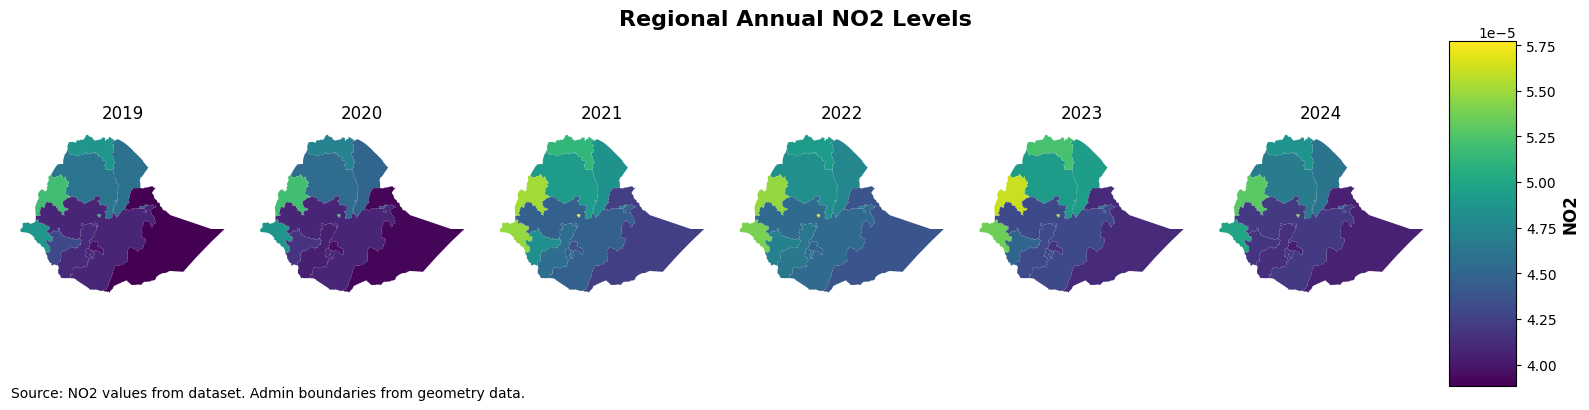

In [89]:
fig = plot_regional_timeseries(
    df=air_pollution_annual_adm1, 
    variable_column='NO2',
    geometry_df=ethiopia_adm1, #title = 'NO2 trends at '
)

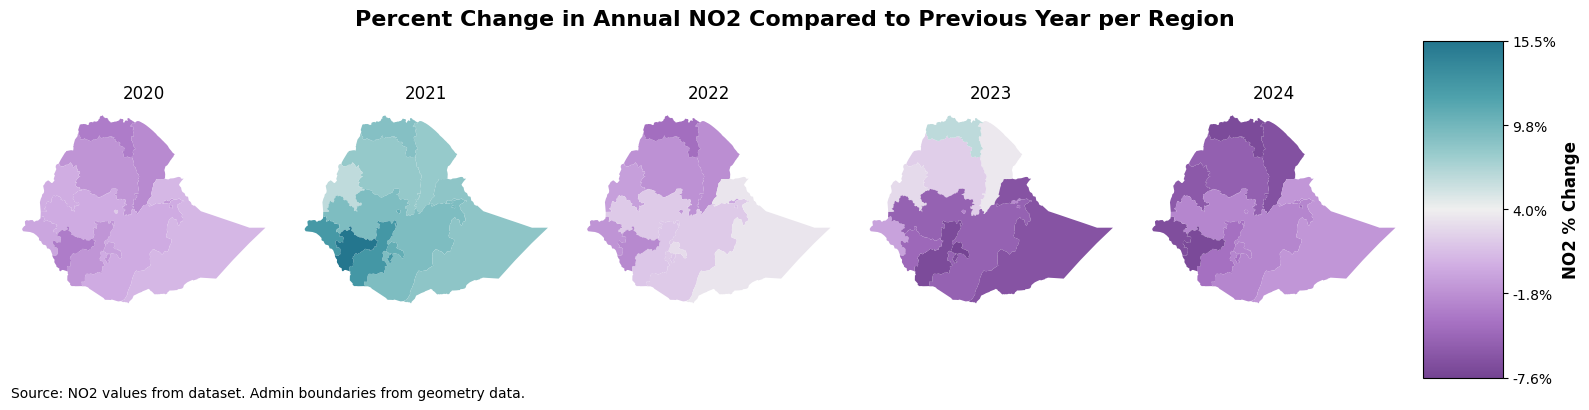

In [90]:
fig = plot_regional_timeseries(
    df=air_pollution_annual_adm1, 
    variable_column='NO2',
    geometry_df=ethiopia_adm1,
    #base_year=2019, 
    pc_change=True,
    percent_change_column='percent_change_NO2_PY',
    exclude_years=[2019],
    title='Percent Change in Annual NO2 Compared to Previous Year per Region'
)

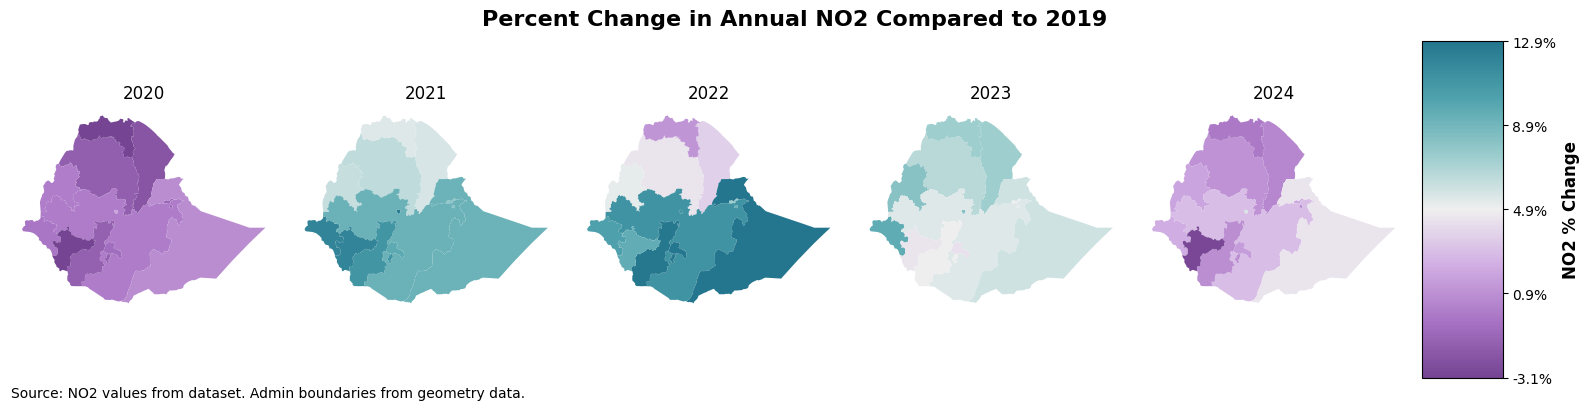

In [91]:
fig = plot_regional_timeseries(
    df=air_pollution_annual_adm1, 
    variable_column='NO2',
    geometry_df=ethiopia_adm1,
    #base_year=2019, 
    pc_change=True,
    percent_change_column='percent_change_NO2_2019',
    exclude_years=[2019],
    title='Percent Change in Annual NO2 Compared to 2019'
)

### Zonal Changes in Pollution

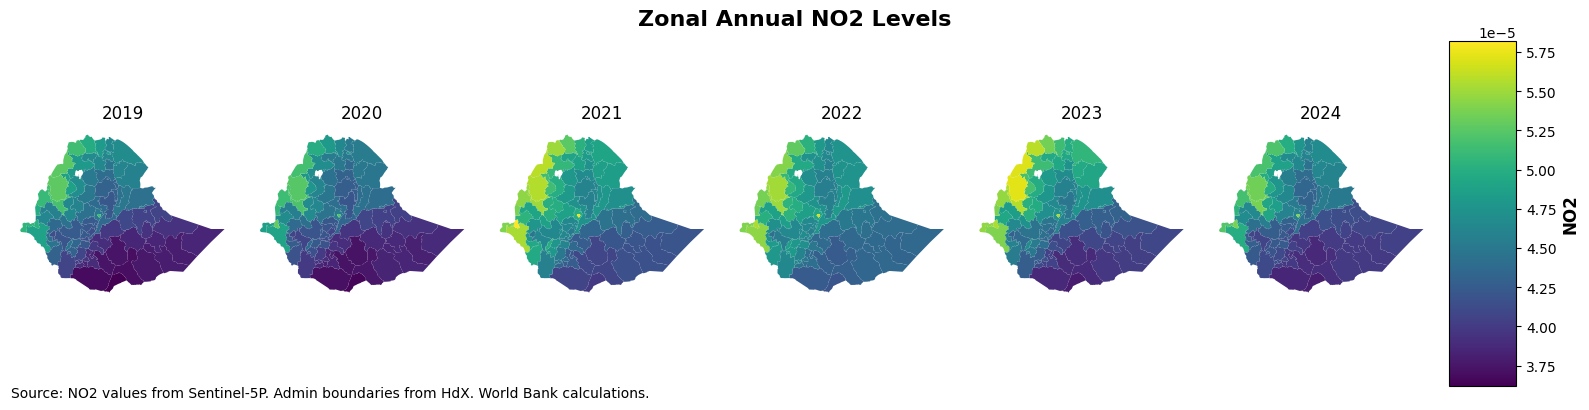

In [96]:
fig = plot_regional_timeseries(
    df=air_pollution_annual_adm2, 
    variable_column='NO2',
    geometry_df=ethiopia_adm2, 
    geometry_region_column='ADM2_EN',
    region_column ='ADM2_EN',
    title = 'Zonal Annual NO2 Levels',
    #highlight_regions=['Dire Dawa urban', 'Dire Dawa rural'],
    #exclude_years=[2019,2020,2021]
)

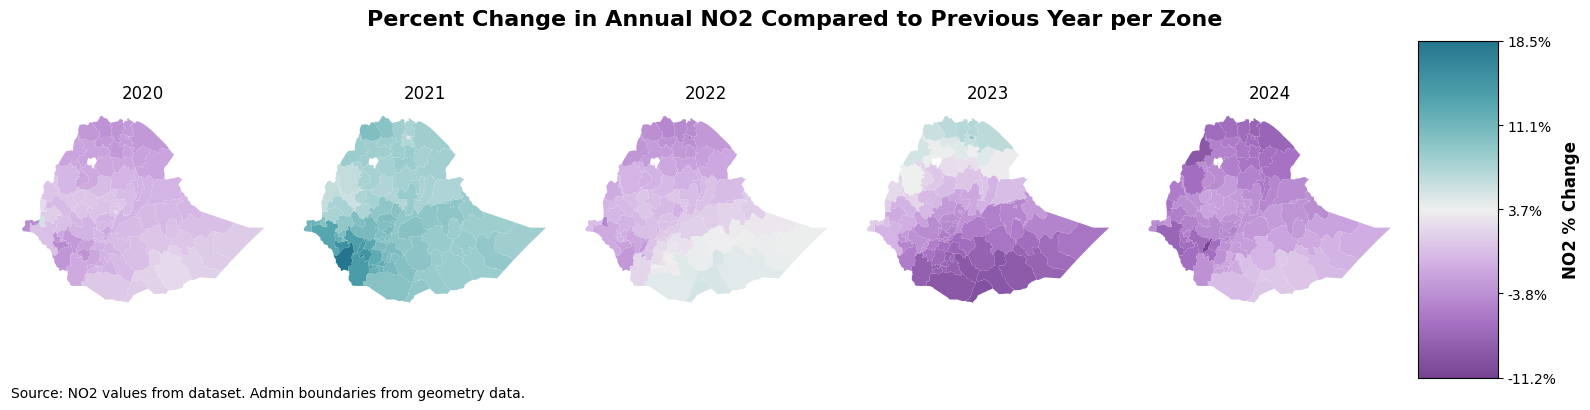

In [87]:
fig = plot_regional_timeseries(
    df=air_pollution_annual_adm2, 
    variable_column='NO2',
    geometry_df=ethiopia_adm2,
    #base_year=2019, 
    pc_change=True,
    percent_change_column='percent_change_NO2_PY',
    exclude_years=[2019],
    title='Percent Change in Annual NO2 Compared to Previous Year per Zone',
     geometry_region_column='ADM2_EN',
    region_column ='ADM2_EN'
)

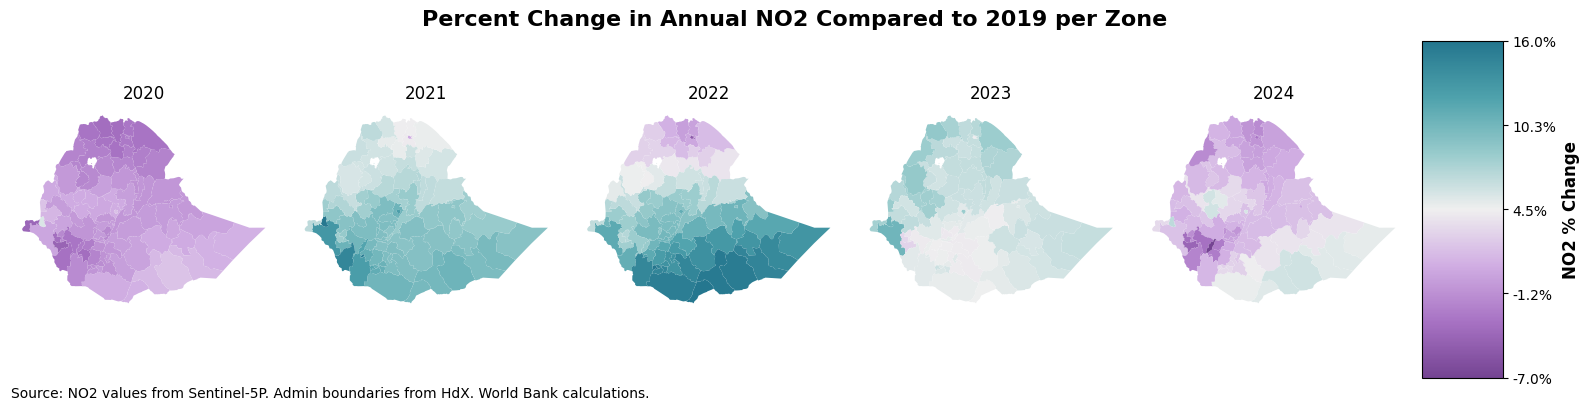

In [97]:
fig = plot_regional_timeseries(
    df=air_pollution_annual_adm2, 
    variable_column='NO2',
    geometry_df=ethiopia_adm2,
    #base_year=2019, 
    pc_change=True,
    percent_change_column='percent_change_NO2_2019',
    exclude_years=[2019],
    title='Percent Change in Annual NO2 Compared to 2019 per Zone',
     geometry_region_column='ADM2_EN',
    region_column ='ADM2_EN'
)

### Manufacturing Areas
**Did pollution occur more in manufaturing areas?**

We consider Dire Dawa to be the industrial zone in Ethiopia

In [98]:
manufacturing_woredas = air_pollution_annual_adm3[air_pollution_annual_adm3['ADM2_EN'].isin(['Dire Dawa rural', 'Dire Dawa urban'])]['ADM3_EN'].unique()

In [38]:
# air_pollution_annual_adm3_gdf.rename(columns={'date':'event_date', 'mean':'NO2'}, inplace=True)
# air_pollution_annual_adm3.rename(columns={'date':'event_date', 'mean':'NO2'}, inplace=True)
air_pollution_monthly_adm3.rename(columns={'date':'event_date', 'mean':'NO2'}, inplace=True)


In [ ]:
air_pollution_annual_adm3_gdf = get_annual_baseline(air_pollution_annual_adm3_gdf, group_column= 'ADM3_EN', baseline_year=2019)
air_pollution_annual_adm3 = get_annual_baseline(air_pollution_annual_adm3, group_column= 'ADM3_EN', baseline_year=2019)

air_pollution_annual_adm3_gdf = get_annual_baseline(air_pollution_annual_adm3_gdf, group_column= 'ADM3_EN', baseline_year='PY')
air_pollution_annual_adm3 = get_annual_baseline(air_pollution_annual_adm3, group_column= 'ADM3_EN', baseline_year='PY')

In [39]:
air_pollution_monthly_adm3 = get_monthly_baseline(air_pollution_monthly_adm3, group_column= 'ADM3_EN', baseline_year=2019)
air_pollution_monthly_adm3 = get_monthly_baseline(air_pollution_monthly_adm3, group_column= 'ADM3_EN', baseline_year='PY')


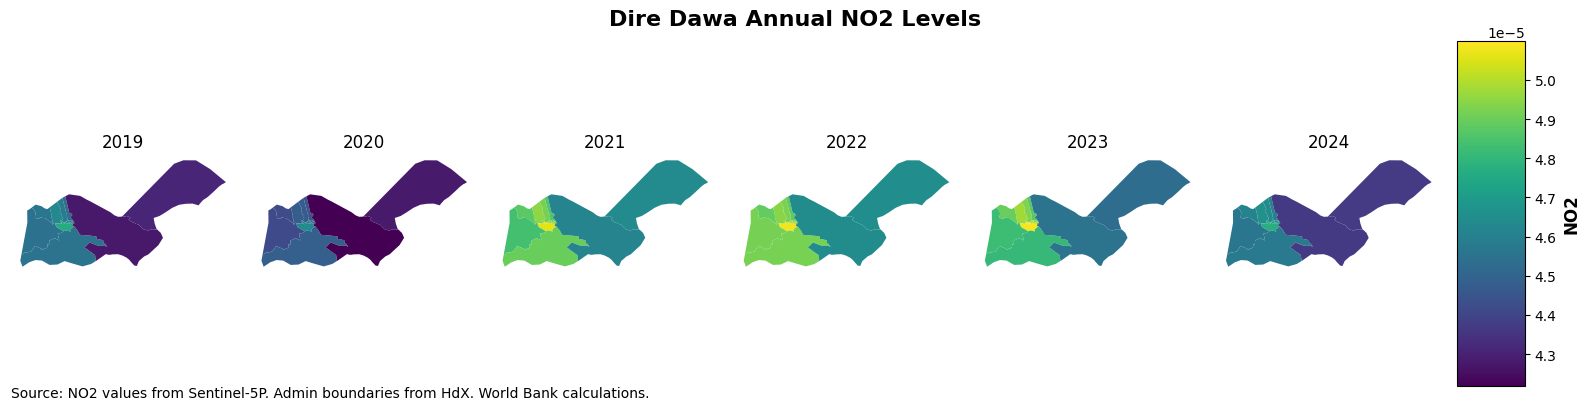

In [101]:
fig = plot_regional_timeseries(
    df=air_pollution_annual_adm3[air_pollution_annual_adm3['ADM3_EN'].isin(manufacturing_woredas)].copy(), 
    variable_column='NO2',
    geometry_df=ethiopia_adm3[ethiopia_adm3['ADM3_EN'].isin(manufacturing_woredas)].copy(), 
    geometry_region_column='ADM3_EN',
    region_column ='ADM3_EN',
    title = 'Dire Dawa Annual NO2 Levels',
    #highlight_regions=['Dire Dawa urban', 'Dire Dawa rural'],
    #exclude_years=[2019,2020,2021]
)

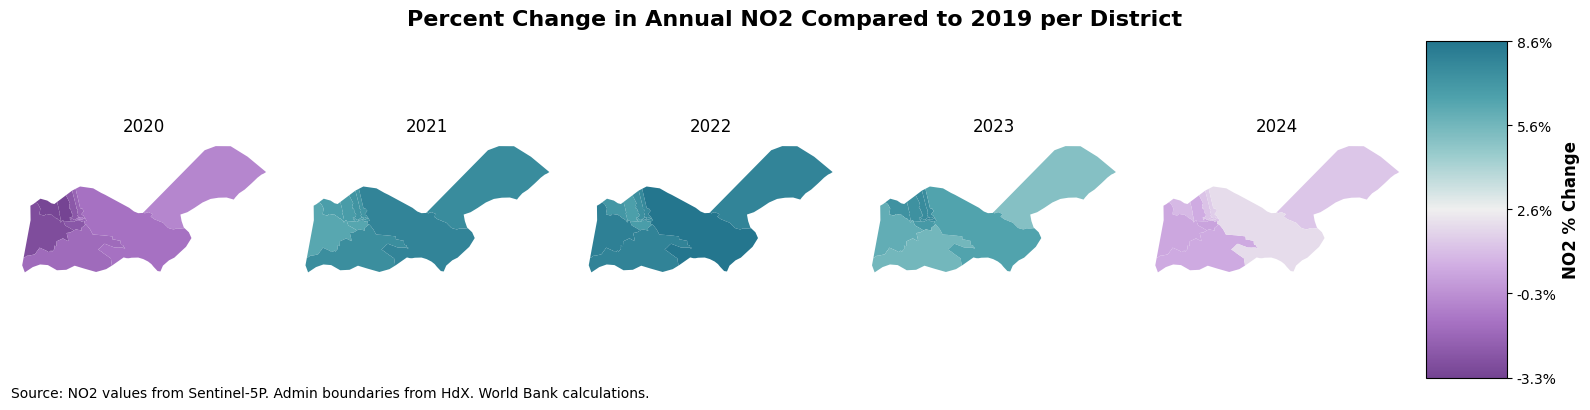

In [104]:
fig = plot_regional_timeseries(
    df=air_pollution_annual_adm3[air_pollution_annual_adm3['ADM3_EN'].isin(manufacturing_woredas)].copy(), 
    variable_column='NO2',
    geometry_df=ethiopia_adm3[ethiopia_adm3['ADM3_EN'].isin(manufacturing_woredas)].copy(),
    #base_year=2019, 
    pc_change=True,
    percent_change_column='percent_change_NO2_2019',
    exclude_years=[2019],
    title='Percent Change in Annual NO2 Compared to 2019 per District',
     geometry_region_column='ADM3_EN',
    region_column ='ADM3_EN'
)

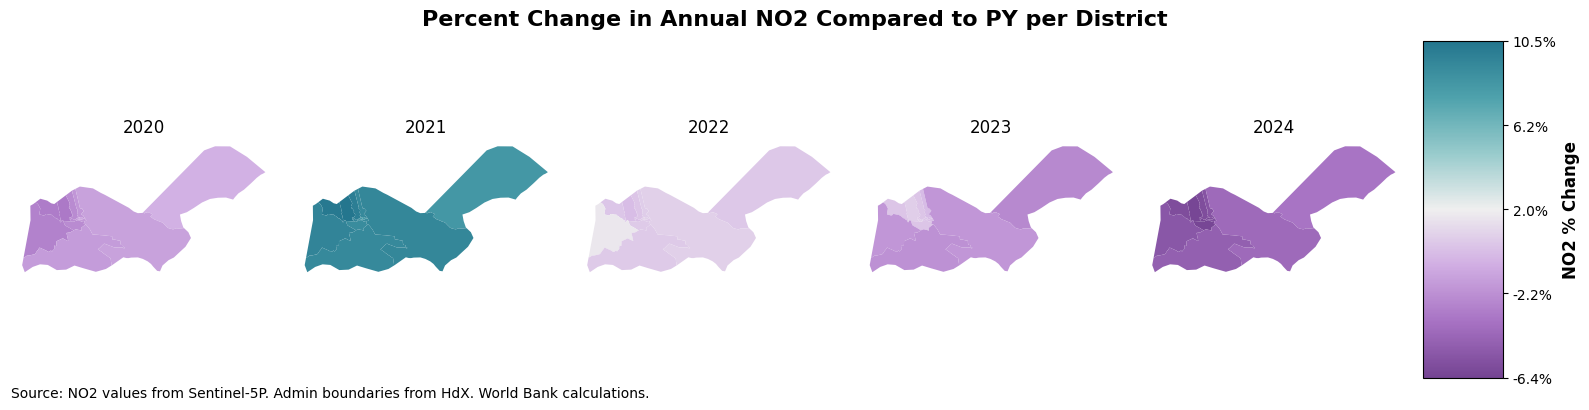

In [103]:
fig = plot_regional_timeseries(
    df=air_pollution_annual_adm3[air_pollution_annual_adm3['ADM3_EN'].isin(manufacturing_woredas)].copy(), 
    variable_column='NO2',
    geometry_df=ethiopia_adm3[ethiopia_adm3['ADM3_EN'].isin(manufacturing_woredas)].copy(),
    #base_year=2019, 
    pc_change=True,
    percent_change_column='percent_change_NO2_PY',
    exclude_years=[2019],
    title='Percent Change in Annual NO2 Compared to PY per District',
     geometry_region_column='ADM3_EN',
    region_column ='ADM3_EN'
)

### Temporal Trends in Manufacturing zones

In [57]:
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel
bokeh.core.validation.silence(MISSING_RENDERERS, True)


output_notebook()

# Grouping and calculating the monthly mean by aoi
df = air_pollution_annual_adm3[air_pollution_annual_adm3['ADM3_EN'].isin(manufacturing_woredas)].copy()
df['year'] = pd.DatetimeIndex(df['event_date']).year

tabs = []
labels = ['Annual Regional Air Pollution', '% Change in Regional Air Pollution compared to 2019', '% Change in Regional Air Pollution Compared to Previous Year']


for idx, measure in enumerate(['NO2', 'percent_change_NO2_2019', 'percent_change_NO2_PY']):
    # Get the line plot for monthly NO2
    p = visuals.get_line_plot(
                df,
                labels[idx],
                "Source: Sentinel 5-P extracted from Google Earth Engine",
                subtitle = "",
                category = 'ADM3_EN',
                measure=measure
    )

    # # Add a line for yearly averages
    # # Assuming you have a way to map the 'year' values to a datetime format for the x-axis in the plot
    # p.children[1].line(x=pd.to_datetime(air_pollution_annual_adm1['event_date'].dt.year, format='%Y'), y=air_pollution_annual_adm1[measure], 
    #     line_width=2, color='red', legend_label=f'Yearly Average {measure}')
    
    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with both the monthly and yearly average lines
tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

In [56]:
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel
bokeh.core.validation.silence(MISSING_RENDERERS, True)


output_notebook()

# Grouping and calculating the monthly mean by aoi
df = air_pollution_monthly_adm3[air_pollution_monthly_adm3['ADM3_EN'].isin(manufacturing_woredas)].copy()
df['year'] = pd.DatetimeIndex(df['event_date']).year

tabs = []
labels = ['Monthly Regional Air Pollution', '% Change in Regional Air Pollution compared to 2019', '% Change in Regional Air Pollution Compared to Previous Year']


for idx, measure in enumerate(['NO2', 'percent_change_NO2_2019', 'percent_change_NO2_PY']):
    # Get the line plot for monthly NO2
    p = visuals.get_line_plot(
                df,
                labels[idx],
                "Source: Sentinel 5-P extracted from Google Earth Engine",
                subtitle = "",
                category = 'ADM3_EN',
                measure=measure
    )

    # # Add a line for yearly averages
    # # Assuming you have a way to map the 'year' values to a datetime format for the x-axis in the plot
    # p.children[1].line(x=pd.to_datetime(air_pollution_annual_adm1['event_date'].dt.year, format='%Y'), y=air_pollution_annual_adm1[measure], 
    #     line_width=2, color='red', legend_label=f'Yearly Average {measure}')
    
    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with both the monthly and yearly average lines
tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

In [5]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Example: Load your points (these are the center points of the 1.1 km boxes)
# Replace this with your actual points GeoDataFrame
points = analysis.convert_to_gdf(air_pollution[['latitude', 'longitude']].drop_duplicates())

# Step 1: Reproject to a local UTM projection to work in meters
points_utm = points.to_crs(epsg=32633)  # Adjust UTM zone based on your region

# Step 2: Create 1.1 km x 1.1 km boxes around each center point
cell_size = 1100  # 1.1 km in meters
half_size = cell_size / 2

def create_box_around_point(point, half_size):
    """Create a 1.1 km x 1.1 km box (Polygon) around a point."""
    x, y = point.x, point.y
    return Polygon([(x - half_size, y - half_size), 
                    (x + half_size, y - half_size), 
                    (x + half_size, y + half_size), 
                    (x - half_size, y + half_size)])

# Apply the function to create boxes around each point
boxes = points_utm['geometry'].apply(lambda point: create_box_around_point(point, half_size))

# Step 3: Create a new GeoDataFrame with the boxes
boxes_gdf = gpd.GeoDataFrame(geometry=boxes, crs=points_utm.crs)

# Step 4: Reproject back to WGS84 if needed (optional)
boxes_wgs84 = boxes_gdf.to_crs(epsg=4326)


In [7]:
boxes_wgs84.to_file('../../data/air_pollution/ethiopia_no2_polygons.shp')